# Image Data Cleaning

## Intro & Objectives <a name="intro"></a>

The purpose of this notebook was to sort through and clean a directory composed of archived files containing Google Street View (GSV) images for a given city. This process was specific to our project and may therefore not be applicable in other contexts. 

The folder structure was the following:

`City_A
    File_1.zip
        lattitude_longitude_verticalrotation_horizontalrotation.jpg
        lattitude_longitude_verticalrotation_horizontalrotation.jpg
        lattitude_longitude_verticalrotation_horizontalrotation.jpg
        ...
    File_2.zip
        lattitude_longitude_verticalrotation_horizontalrotation.jpg
        lattitude_longitude_verticalrotation_horizontalrotation.jpg
        lattitude_longitude_verticalrotation_horizontalrotation.jpg
        ...
    File_3.zip
        lattitude_longitude_verticalrotation_horizontalrotation.jpg
        lattitude_longitude_verticalrotation_horizontalrotation.jpg
        lattitude_longitude_verticalrotation_horizontalrotation.jpg
        ...
    ...`

Each city contained hundreds of zip files and each zip file contained thousands of GSV images within a certain area of the given city. The goal was to conserve zip files with GSV images within our area of interest for that given city. The area of interest was given by the latitude/longitude of a center point and radius around that point. The radius was calculated such that 

<br />
$$R = \frac{POP}{MINSIZE}^{\frac{POPEXP * AREAFACTOR}{π}}$$
where 

- POP = city population size
- MINSIZE = 300000
- POPEXP = 0.85
- AREAFACTOR = 28.27
- π = 3.1415926

The workflow is as follows:

1. [Unzipping Folders](#sec1)
2. [Renaming Extracted Files](#sec2)
3. [Extracting New File Names](#sec3)
4. [Sorting Coordinates Outside Area of Interest](#sec4)
5. [Deleting Files Outside Area of Interest](#sec5)

## Unzipping Folders <a name="sec1"></a>

Once all archived files containing GSV images have been downloaded, run the following code to unzip all files and delete zip files once done:

In [ ]:
# Import libraries
import zipfile, os, glob
import pandas as pd
import geopy.distance
import shutil

# Set working directory
working_directory = '/Users/username/directory/'
os.chdir(working_directory)

# Unzip files
for file in os.listdir(working_directory):   # get list of files
    if zipfile.is_zipfile(file): # if zipfile, extract it
        with zipfile.ZipFile(file) as item: # treat file as a zip
           item.extractall()  # extract it in the working directory
    
# Delete zip files
for zippath in glob.iglob(os.path.join(working_directory, '*.zip')):
    os.remove(zippath)

Before moving on, if you are using a MacOS check your directory and make sure to delete the `__MACOSX` file if it has been created by your system.

## Renaming Extracted Files <a name="sec2"></a>

Once all files have been extracted, the following code will rename the newly extracted files using the name of the first GSV image contained within each of the newly extracted files. As described in the folder structure in the introduction, the GSV image names contain information on coordinates and spatial rotation for each image. The purpose of this step is therefore to give a meaningful name to the newly extracted files by assigning them coordinates.

In [ ]:
# Create list of paths to rename
renames = []

# Walk current directory
for (root, dirs, files) in os.walk('.'):
    # Skip this directory (cannot rename current directory)
    if root == '.': continue
    # Add renaming to list
    renames.append((root, files[0]))

# Iterate renaming list in reverse order so deepest directories are renamed first
for root, new_name in reversed(renames):
    # Make new full directory name (relative to current directory)
    new_full_name = os.path.join(os.path.dirname(root), new_name)
    # Rename, removing .jpg extension from name
    os.rename(root, new_full_name[:-4]) 

## Extracting New File Names <a name="sec3"></a>

Once all files have been renamed, their names can be extracted into a list (for tracking purposes) and a dataframe (for manipulation purposes).

In [ ]:
# Creating function to ignore hidden files
def listdir_nohidden(path):
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f
            
# List all files in directory, except hidden files
file_list = [f for f in listdir_nohidden(working_directory)]

# Convert list to dataframe
df_files = pd.DataFrame({'name':file_list})

# Split lat/long/rot1/rot2 into separate columns
df_files = df_files.name.apply(lambda x: pd.Series(str(x).split("_")))

## Sorting Coordinates Outside Area of Interest <a name="sec4"></a>

Now that all file names have been extracted into a dataframe, the next step is to flag the file names containing coordinates outside of the area of interest. As mentioned in the [introduction](#intro), the area of interest is the area around a central point in the city, up to a certain distance given by the radius R. This can be visualized as follows:

<br />
<div>
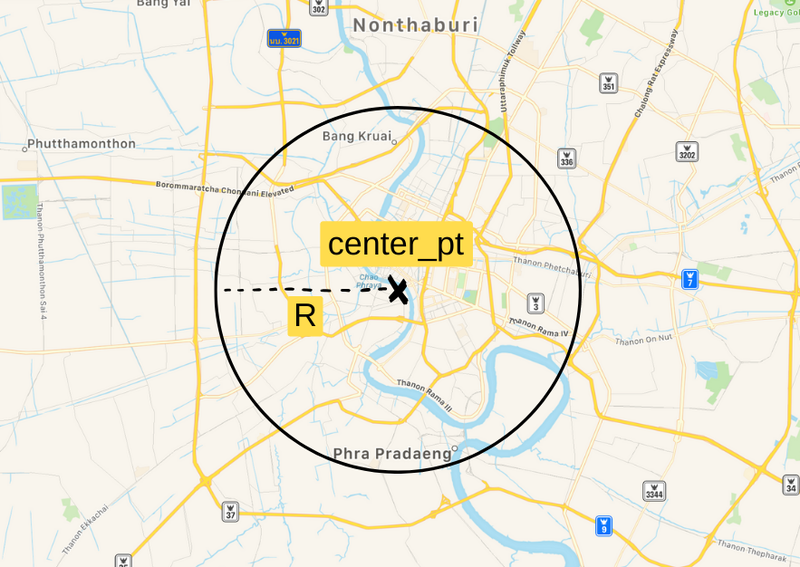
</div>
<br />

There are 3 steps to follow here:

1. Assign the coordinates of the central point you have chosen for the given city to the variable `center_pt`. The input should be a tuple such that `center_pt = (lattitude, longitude)` .
2. Assign the calculated radius for the given city to the variable `radius`.
3. Run block of code.

In [ ]:
# Create tracking dataframe
df_track = df_files

# Define desired center point lat/long & radius
center_pt = (13.72, 100.53)
radius = 12.8941761

# Apply geo-distance calculation to dataframe, if distance from center_pt > radius, out of reach col = 1
df_track['out_of_reach'] = df_track.apply(lambda row: geopy.distance.distance(center_pt, (row[0], row[1])).km > radius, axis=1)

# Drop files that are out of reach in original dataframe, exclude last column
df_files = df_track.drop(df_track[df_track.out_of_reach == 1].index).iloc[:,:-1]

# Create list of files to keep
file_list_keep = df_files[0:3].apply(lambda row: '_'.join(row.values.astype(str)), axis=1).to_list()

## Deleting Files Outside Area of Interest <a name="sec5"></a>

This final step deletes the files that are outside the area of interest, allowing you to keep only GSV images within the area of interest.

In [ ]:
# Delete files not in list
for filename in listdir_nohidden(working_directory):
    if filename not in file_list_keep:
        shutil.rmtree(filename)